EDA questions:

Condo and pool?

How does having a pool affect property values?

Does garage type matter? Is just T/F enough or do we need number of spaces?

Do we want to include buying multi-family? 

Do we want to include the manufactured properties? They seem to be mostly mobile homes, but there are some single family homes mixed in.

Need to look at floor count

filtering out outliers in price

how has the sale price changed over the course of the year

drop propertyType apartment, Multi-Family, Manufactured, maybe/probably Land, probably Townhouse
use isin to get just 
data = data[data['propertyType'].isin(['Single Family','Condo'])]



Encoding cities using numbers based on some aggregated price -- might be like artificially weighting since it overlaps completely with location

In [215]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [216]:
# Loading data from SQLite to pandas

path_to_db = '/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,...,0,2.0,None,0,NaN,None,True,NaN,1.0,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,0,1.0,None,1,4.0,Garage,False,NaN,1.0,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [217]:
data.shape

(145617, 35)

In [218]:
# Confirming no duplicates (dropped before converting original csv to database)

data.duplicated().any()

np.False_

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145617 entries, 0 to 145616
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  int64  
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  zoning            86564 non-null   object 
 16  lastSaleDate      14

In [220]:
# Dropping columns with few values

drop_cols = ['zoning','hoa','architectureType','coolingType','heatingType','garageSpaces','garageType','roomCount','viewType','foundationType','exteriorType']

data = data.drop(drop_cols, axis=1)
data.shape

(145617, 24)

In [221]:
data.columns.tolist()

['id',
 'formattedAddress',
 'city',
 'state',
 'zipCode',
 'county',
 'latitude',
 'longitude',
 'propertyType',
 'bedrooms',
 'bathrooms',
 'squareFootage',
 'lotSize',
 'yearBuilt',
 'subdivision',
 'lastSaleDate',
 'lastSalePrice',
 'cooling',
 'heating',
 'fireplace',
 'floorCount',
 'garage',
 'pool',
 'unitCount']

In [222]:
county_counts = data['county'].value_counts()
county_counts.head(60)

county
Broward         10772
Palm Beach       9779
Miami-Dade       9657
Lee              9104
Hillsborough     8352
Pinellas         7571
Polk             6998
Orange           6929
Duval            6392
Pasco            6345
Sarasota         5109
Volusia          4466
Manatee          4424
Brevard          4076
Collier          3664
Marion           3636
Osceola          3575
Charlotte        3258
Lake             3249
Saint Johns      2786
Seminole         2518
Saint Lucie      2120
Bay              1838
Escambia         1603
Sumter           1502
Flagler          1344
Hernando         1304
Clay             1298
Citrus           1274
Alachua          1148
Leon             1132
Okaloosa         1102
Indian River     1070
Martin            850
Highlands         831
Walton            783
St. Lucie         616
Nassau            509
Monroe            470
St. Johns         349
Putnam            288
Santa Rosa        242
Hendry            215
Wakulla           117
Okeechobee         94
Col

In [223]:
# Creating column with average 30 year mortgage rates by month

data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

data['year_month'] = data['lastSaleDate'].dt.to_period('M')

m_rate = {
    '2024-03':0.0682,
    '2024-04':0.0699,
    '2024-05':0.076,
    '2024-06':0.0692,
    '2024-07':0.0685,
    '2024-08':0.065,
    '2024-09':0.0618,
    '2024-10':0.0643,
    '2024-11':0.0681,
    '2024-12':0.0672,
    '2025-01':0.0696,
    '2025-02':0.0684,
    '2025-03':0.0668
}

data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

data['m_rate'] = data['year_month'].map(m_rate)


/tmp/ipykernel_28283/117635043.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['lastSaleDate'].dt.to_period('M')


In [224]:
data['year_month'].value_counts()

year_month
2024-04    32063
2024-05    31399
2024-06    25888
2024-07    21176
2024-03    18580
2024-08     3462
2024-10     2714
2024-09     2621
2024-11     2547
2024-12     2413
2025-01     1817
2025-02      931
2025-03        6
Name: count, dtype: int64

In [225]:
data['m_rate']

0         0.0682
1         0.0682
2         0.0682
3         0.0682
4         0.0682
           ...  
145612    0.0692
145613    0.0692
145614    0.0692
145615    0.0692
145616    0.0692
Name: m_rate, Length: 145617, dtype: float64

In [226]:
data['city'].value_counts()

city
Jacksonville            5997
Miami                   4842
Orlando                 4248
Tampa                   4023
Naples                  3132
                        ... 
Seville                    1
Bristol                    1
Jupiter Inlet Colony       1
Key Colony                 1
La Crosse                  1
Name: count, Length: 577, dtype: int64

# EDA on sale prices

In [227]:
data['lastSalePrice'].describe()

count    1.455330e+05
mean     6.225085e+05
std      2.339231e+06
min      3.000000e+02
25%      2.600000e+05
50%      3.760000e+05
75%      5.550000e+05
max      3.450000e+08
Name: lastSalePrice, dtype: float64

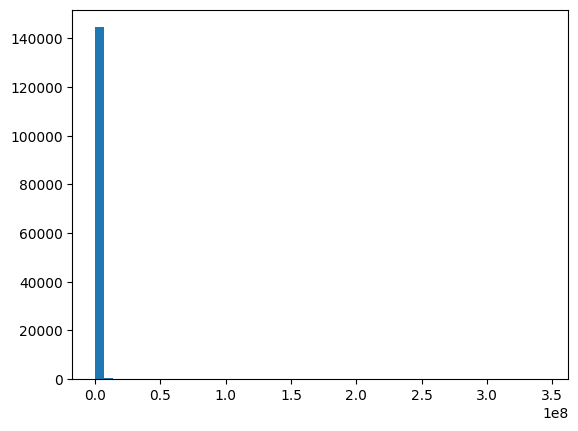

In [228]:
plt.hist(data['lastSalePrice'], bins=50)
plt.show()

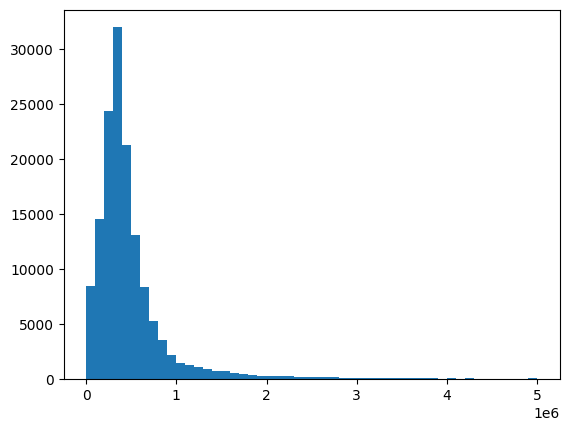

In [229]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,5000000))
plt.show()


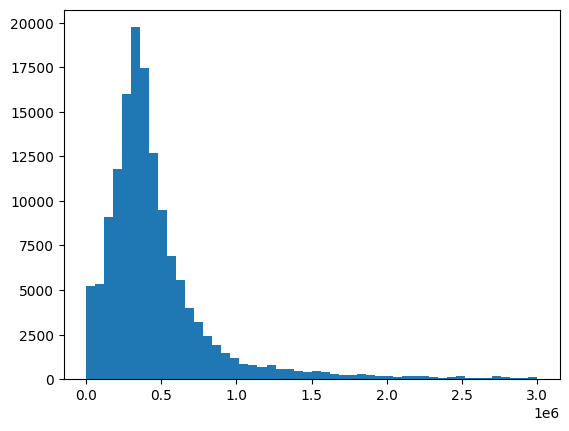

In [230]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,3000000))
plt.show()

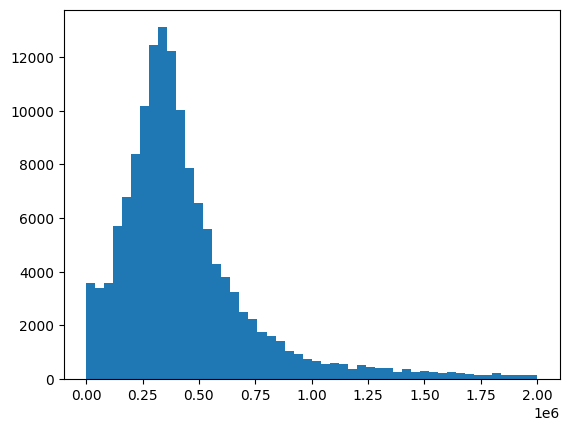

In [231]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,2000000))
plt.show()

# EDA on unitCount

In [232]:
data['unitCount'].describe()

count    96266.000000
mean         1.190493
std         25.374905
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       5760.000000
Name: unitCount, dtype: float64

Massive range of values, but the majority of properties are single unit.

# EDA on propertyType

In [233]:
data['propertyType'].value_counts()

propertyType
Single Family    99845
Condo            22687
Land             12123
Manufactured      3834
Multi-Family      2417
Townhouse         1842
Apartment          556
Name: count, dtype: int64

Most properties are condo or single family.

In [234]:
# Looking at propertyType --> Land

land = data[data['propertyType'] == 'Land']
land.shape

(12123, 26)

In [235]:
land.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,m_rate
count,12123.000000,12123.000000,12123.000000,5001.000000,5096.000000,5095.000000,1.142200e+04,4304.000000,1.205900e+04,12123.000000,12123.000000,12123.000000,645.000000,12123.000000,586.000000,12123.000000
mean,33760.805081,27.930937,-81.922392,3.399720,2.423764,1954.713837,2.595635e+04,2013.439591,7.527074e+05,0.045121,0.046523,0.008744,1.113178,0.025159,1.071672,0.070080
std,788.946508,1.107680,1.019182,0.917383,0.743719,1820.084495,1.962542e+05,25.416806,3.002084e+06,0.207578,0.210624,0.093102,0.321917,0.156614,0.518033,0.003379
min,32009.000000,24.554356,-87.492508,0.000000,1.000000,100.000000,4.000000e+00,1700.000000,5.100000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.061800
25%,33513.000000,27.024100,-82.323048,3.000000,2.000000,1560.000000,5.528000e+03,2023.000000,1.473000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.068400
50%,33928.000000,27.977042,-81.791403,3.000000,2.500000,1828.000000,7.841000e+03,2024.000000,3.700000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.069200
75%,34275.000000,28.503073,-81.489770,4.000000,3.000000,2207.000000,1.089000e+04,2024.000000,5.323000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.069900
max,34997.000000,30.992581,-80.035828,20.000000,17.000000,121992.000000,8.140057e+06,2027.000000,8.500000e+07,1.000000,1.000000,1.000000,3.000000,1.000000,9.000000,0.076000


In [236]:
# Range of values for Land

# plt.scatter(x=land.id, y=land.lastSalePrice)
# plt.show()

Assuming this property type is empty land on which to build, there are a surprsing number of bedrooms, bathrooms, etc. 

Rows with this property type may need to be dropped from the model.

In [237]:
# Looking at propertyType --> Manufactured

manufactured = data[data['propertyType'] == 'Manufactured']
manufactured.shape

(3834, 26)

In [238]:
manufactured.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,m_rate
count,3834.000000,3834.000000,3834.000000,3395.000000,3585.000000,3803.000000,3.747000e+03,3808.000000,3.834000e+03,3834.000000,3834.000000,3834.000000,2853.000000,3834.000000,3297.000000,3834.000000
mean,33589.934011,28.169024,-81.968781,2.432106,1.796374,1125.888772,3.419714e+04,1986.935137,1.826119e+05,0.695097,0.689098,0.072770,1.002804,0.582681,2.519867,0.070281
std,855.974223,1.199170,1.069604,0.723195,0.452964,439.710224,2.012001e+05,14.563097,5.369107e+05,0.460427,0.462923,0.259792,0.052888,0.493181,87.060970,0.003337
min,32003.000000,24.566139,-87.510107,1.000000,1.000000,60.000000,1.000000e+00,1900.000000,6.000000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.061800
25%,32907.000000,27.451554,-82.377048,2.000000,2.000000,820.000000,4.755000e+03,1976.000000,9.370000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.068500
50%,33810.000000,28.197868,-81.942557,2.000000,2.000000,1104.000000,7.153000e+03,1985.000000,1.500000e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.069200
75%,34228.000000,28.946323,-81.576930,3.000000,2.000000,1380.000000,1.655300e+04,1997.000000,2.100000e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.069900
max,34997.000000,30.946223,-80.060530,7.000000,4.000000,8750.000000,5.462023e+06,2025.000000,2.250000e+07,1.000000,1.000000,1.000000,2.000000,1.000000,5000.000000,0.076000


In [239]:
# It looks like this is mostly single units, but the max is 5,000 for units

manufactured['unitCount'].value_counts()

unitCount
1.0       3286
2.0          9
5000.0       1
4.0          1
Name: count, dtype: int64

In [240]:
# Looking at the outlier

manufactured[manufactured['unitCount'] == 5000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,year_month,m_rate
9089,"20300-Leonard-Rd,-Lot-51,-Lutz,-FL-33558","20300 Leonard Rd, Lot 51, Lutz, FL 33558",Lutz,FL,33558,Pasco,28.185959,-82.480042,Manufactured,NaN,...,245000.0,1,1,0,1.0,0,False,5000.0,2024-03,0.0682


From checking Zillow on this address, this is an entire condo complex--probably outside the scope of the project.

What are the single-unit properties in this category like?

In [241]:
manufactured = manufactured[manufactured['unitCount'] == 1.0]
manufactured.head(25)

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,year_month,m_rate
67,"8709-S-Meadowview-Cir,-Tampa,-FL-33625","8709 S Meadowview Cir, Tampa, FL 33625",Tampa,FL,33625,Hillsborough,28.053556,-82.577342,Manufactured,2.0,...,225000.0,1,1,0,1.0,1,False,1.0,2024-03,0.0682
97,"3141-Old-Farm-House-Dr,-North-Fort-Myers,-FL-3...","3141 Old Farm House Dr, North Fort Myers, FL 3...",North Fort Myers,FL,33917,Lee,26.709915,-81.895790,Manufactured,2.0,...,165000.0,1,1,0,1.0,1,False,1.0,2024-03,0.0682
98,"128-Torch-Ln,-North-Fort-Myers,-FL-33917","128 Torch Ln, North Fort Myers, FL 33917",North Fort Myers,FL,33917,Lee,26.692646,-81.859562,Manufactured,2.0,...,60000.0,1,1,0,1.0,1,False,1.0,2024-03,0.0682
137,"16-Golden-Gate-Cir,-Port-Orange,-FL-32129","16 Golden Gate Cir, Port Orange, FL 32129",Port Orange,FL,32129,Volusia,29.136491,-81.017564,Manufactured,3.0,...,229900.0,1,1,1,1.0,1,False,1.0,2024-03,0.0682
196,"110-Nw-53rd-St,-Deerfield-Beach,-FL-33064","110 Nw 53rd St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.294703,-80.123712,Manufactured,NaN,...,150000.0,0,0,0,1.0,0,False,1.0,2024-03,0.0682
197,"222-Nw-54th-St,-Deerfield-Beach,-FL-33064","222 Nw 54th St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.296940,-80.125560,Manufactured,NaN,...,149000.0,0,0,0,1.0,0,False,1.0,2024-03,0.0682
296,"1100-Belcher-Rd-S,-Lot-371,-Largo,-FL-33771","1100 Belcher Rd S, Lot 371, Largo, FL 33771",Largo,FL,33771,Pinellas,27.905466,-82.750327,Manufactured,2.0,...,95000.0,1,1,0,1.0,1,True,1.0,2024-03,0.0682
323,"207-E-Harris-St,-Palatka,-FL-32177","207 E Harris St, Palatka, FL 32177",Palatka,FL,32177,Putnam,29.660439,-81.653605,Manufactured,3.0,...,123000.0,0,0,0,NaN,0,False,1.0,2024-03,0.0682
471,"220-El-Prado-Pl,-Panama-City-Beach,-FL-32413","220 El Prado Pl, Panama City Beach, FL 32413",Panama City Beach,FL,32413,Bay,30.243290,-85.924014,Manufactured,3.0,...,290000.0,1,1,0,1.0,0,False,1.0,2024-03,0.0682
477,"457-Citrus-Ridge-Dr,-Davenport,-FL-33837","457 Citrus Ridge Dr, Davenport, FL 33837",Davenport,FL,33837,Polk,28.212509,-81.629595,Manufactured,2.0,...,75000.0,0,0,0,NaN,1,False,1.0,2024-03,0.0682


Looking at some of these on Zillow, they seem to be mostly mobile homes with a few single family homes mixed in. 

This category may be fine for the model.

# EDA on multiFamily

In [242]:
multiFamily = data[data['propertyType'] == 'Multi-Family']
multiFamily.shape

(2417, 26)

In [243]:
multiFamily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2417 entries, 26 to 145609
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                2417 non-null   object             
 1   formattedAddress  2417 non-null   object             
 2   city              2417 non-null   object             
 3   state             2417 non-null   object             
 4   zipCode           2417 non-null   int64              
 5   county            2413 non-null   object             
 6   latitude          2417 non-null   float64            
 7   longitude         2417 non-null   float64            
 8   propertyType      2417 non-null   object             
 9   bedrooms          2262 non-null   float64            
 10  bathrooms         2341 non-null   float64            
 11  squareFootage     2358 non-null   float64            
 12  lotSize           2331 non-null   float64            
 13  yearB

In [244]:
# Looking at range of sale values

# plt.scatter(x=multiFamily.id, y=multiFamily.lastSalePrice)
# plt.show()

In [245]:
# What are the 100000000+ million dollar places, and the other outliers over 20,000,000?

multiFamily[multiFamily.lastSalePrice > 20000000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,year_month,m_rate
1339,"1809-Jackson-St,-Unit-619,-Hollywood,-FL-33020","1809 Jackson St, Unit 619, Hollywood, FL 33020",Hollywood,FL,33020,Broward,26.008930,-80.143410,Multi-Family,2.0,...,62000000.0,0,0,0,12.0,1,False,NaN,2024-03,0.0682
15217,"3317-Broadway,-West-Palm-Beach,-FL-33407","3317 Broadway, West Palm Beach, FL 33407",West Palm Beach,FL,33407,Palm Beach,26.743198,-80.056935,Multi-Family,6.0,...,109285714.0,1,1,0,2.0,1,False,NaN,2024-03,0.0682
63068,"1345-W-28th-St,-Apt-2,-Hialeah,-FL-33010","1345 W 28th St, Apt 2, Hialeah, FL 33010",Hialeah,FL,33010,Miami-Dade,25.847361,-80.309305,Multi-Family,2.0,...,20610000.0,0,0,0,NaN,0,False,NaN,2024-05,0.0760
104642,"1495-Spring-Harbor-Dr,-Delray-Beach,-FL-33445","1495 Spring Harbor Dr, Delray Beach, FL 33445",Delray Beach,FL,33445,Palm Beach,26.437936,-80.092683,Multi-Family,1.0,...,111640000.0,0,0,0,NaN,0,False,NaN,2024-07,0.0685
128826,"7960-Pine-Crossings-Cir,-Orlando,-FL-32807","7960 Pine Crossings Cir, Orlando, FL 32807",Orlando,FL,32807,Orange,28.545065,-81.280277,Multi-Family,2.0,...,50000000.0,1,1,1,2.0,1,True,14.0,2024-09,0.0618


From Zillow research, these seem to be either large apartment buildings or innacurate records.

In [246]:
# Looking at the 10 to 20 million range

multiFamily[(multiFamily.lastSalePrice < 20000000) & (multiFamily.lastSalePrice > 10000000)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,year_month,m_rate
24076,"101-Mosswood-Cir,-Winter-Springs,-FL-32708","101 Mosswood Cir, Winter Springs, FL 32708",Winter Springs,FL,32708,Seminole,28.693565,-81.304557,Multi-Family,NaN,...,10514600.0,0,0,0,1.0,0,False,NaN,2024-04,0.0699
24767,"140-Mosswood-Cir,-Winter-Springs,-FL-32708","140 Mosswood Cir, Winter Springs, FL 32708",Winter Springs,FL,32708,Seminole,28.692733,-81.303319,Multi-Family,NaN,...,10514600.0,1,1,0,1.0,0,False,NaN,2024-04,0.0699
74569,"11900-Nw-19th-Ave,-Miami,-FL-33167","11900 Nw 19th Ave, Miami, FL 33167",Miami,FL,33167,Miami-Dade,25.883316,-80.231757,Multi-Family,128.0,...,11000000.0,1,0,0,2.0,1,False,3.0,2024-05,0.0760
125950,"243-Ne-12th-Ave,-Homestead,-FL-33030","243 Ne 12th Ave, Homestead, FL 33030",Homestead,FL,33030,Miami-Dade,25.472529,-80.460070,Multi-Family,62.0,...,14750000.0,1,0,0,2.0,0,False,10.0,2024-08,0.0650
133318,"3681-Sw-60th-Ter,-Apt-4,-Davie,-FL-33314","3681 Sw 60th Ter, Apt 4, Davie, FL 33314",Davie,FL,33314,Broward,26.076095,-80.227879,Multi-Family,6.0,...,11000000.0,0,0,0,2.0,0,0,4.0,2024-11,0.0681
137460,"14555-Ne-6th-Ave,-Unit-106,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 106, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1.0,...,12375000.0,0,0,0,NaN,0,0,NaN,2024-12,0.0672
137464,"14555-Ne-6th-Ave,-Unit-225,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 225, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1.0,...,12375000.0,0,0,0,NaN,0,0,NaN,2024-12,0.0672
137466,"14555-Ne-6th-Ave,-Unit-105,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 105, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1.0,...,12375000.0,0,0,0,NaN,0,0,NaN,2024-12,0.0672


There is a combination of full apartment buildings and individual units. 

Recommend dropping this category--outside of the scope of a web app for home buyers and likely to misinform the model.

# EDA on Townhouse

In [247]:
townhouse = data[data['propertyType'] == 'Townhouse']
townhouse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1842 entries, 1 to 145450
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                1842 non-null   object             
 1   formattedAddress  1842 non-null   object             
 2   city              1842 non-null   object             
 3   state             1842 non-null   object             
 4   zipCode           1842 non-null   int64              
 5   county            1829 non-null   object             
 6   latitude          1842 non-null   float64            
 7   longitude         1842 non-null   float64            
 8   propertyType      1842 non-null   object             
 9   bedrooms          1839 non-null   float64            
 10  bathrooms         1840 non-null   float64            
 11  squareFootage     1817 non-null   float64            
 12  lotSize           1387 non-null   float64            
 13  yearBu

In [248]:
townhouse.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,m_rate
count,1842.000000,1842.000000,1842.000000,1839.000000,1840.000000,1817.000000,1.387000e+03,1734.000000,1.839000e+03,1842.000000,1842.000000,1842.000000,725.000000,1842.000000,681.000000,1842.000000
mean,33364.624864,27.744514,-81.486341,2.748233,2.406793,1560.687947,5.108288e+04,2003.771050,1.077664e+06,0.295331,0.268730,0.029316,1.782069,0.260043,1.455213,0.068313
std,787.724513,1.495924,1.504871,0.651620,0.560512,561.883220,1.057552e+06,18.660914,3.841078e+06,0.456315,0.443419,0.168736,0.525019,0.438777,8.355597,0.003668
min,32003.000000,24.552934,-87.444341,1.000000,1.000000,450.000000,5.900000e+01,1900.000000,4.100000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.061800
25%,32832.750000,26.367468,-82.026854,2.000000,2.000000,1276.000000,1.742000e+03,1986.000000,2.549000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.067200
50%,33341.500000,27.827745,-81.371127,3.000000,2.500000,1507.000000,2.230000e+03,2006.000000,3.443850e+05,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.068400
75%,33837.000000,28.494543,-80.276986,3.000000,2.500000,1750.000000,3.609500e+03,2023.000000,4.800000e+05,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.069600
max,34997.000000,30.956392,-80.039679,6.000000,9.000000,16783.000000,3.794076e+07,2026.000000,3.571429e+07,1.000000,1.000000,1.000000,4.000000,1.000000,200.000000,0.076000


Nothing here seems too unusual, aside from max yearBuilt is 2026--will investigate that whole column. This category may be fine to use.

# EDA on Apartment

In [249]:
apt = data[data['propertyType'] == 'Apartment']
apt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 345 to 145394
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                556 non-null    object             
 1   formattedAddress  556 non-null    object             
 2   city              556 non-null    object             
 3   state             556 non-null    object             
 4   zipCode           556 non-null    int64              
 5   county            555 non-null    object             
 6   latitude          556 non-null    float64            
 7   longitude         556 non-null    float64            
 8   propertyType      556 non-null    object             
 9   bedrooms          491 non-null    float64            
 10  bathrooms         517 non-null    float64            
 11  squareFootage     515 non-null    float64            
 12  lotSize           300 non-null    float64            
 13  yearB

In [250]:
apt.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,m_rate
count,556.000000,556.000000,556.000000,491.000000,517.000000,515.000000,3.000000e+02,502.000000,5.560000e+02,556.000000,556.000000,556.000000,158.000000,556.000000,204.000000,556.000000
mean,33407.872302,27.029756,-80.998241,3.529532,2.061896,2336.458252,7.262281e+05,1974.312749,4.220089e+06,0.203237,0.176259,0.014388,1.259494,0.115108,7.137255,0.068511
std,652.091662,1.354737,1.148613,32.532380,6.269082,9718.911803,1.159184e+07,24.987498,1.522979e+07,0.402770,0.381383,0.119193,0.630240,0.319440,37.591541,0.003507
min,32073.000000,24.660362,-87.314542,0.000000,1.000000,100.000000,2.500000e+01,1700.000000,5.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.061800
25%,33060.000000,25.969537,-81.761924,1.000000,1.000000,685.000000,6.299500e+03,1962.000000,2.250000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.067200
50%,33185.500000,26.255764,-80.311673,2.000000,1.000000,928.000000,1.040800e+04,1972.000000,4.975000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.068500
75%,33755.000000,28.053627,-80.144059,2.000000,2.000000,1374.000000,2.352200e+04,1985.000000,1.360000e+06,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.069600
max,34997.000000,30.433831,-80.032465,720.000000,127.000000,178877.000000,2.008116e+08,2024.000000,1.392500e+08,1.000000,1.000000,1.000000,5.000000,1.000000,352.000000,0.076000


In [251]:
# Looking at a few of the 2 bedroom to check on Zillow

# Need to double check this one

apt[apt['bedrooms'] == 2].head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,year_month,m_rate
1664,"10764-70th-Ave,-Unit-7305,-Seminole,-FL-33772","10764 70th Ave, Unit 7305, Seminole, FL 33772",Seminole,FL,33772,Pinellas,27.835130,-82.788877,Apartment,2.0,...,295000.0,0,0,0,1.0,0,True,1.0,2024-03,0.0682
1872,"200-S-11th-St,-Ste-103,-Leesburg,-FL-34748","200 S 11th St, Ste 103, Leesburg, FL 34748",Leesburg,FL,34748,Lake,28.809777,-81.882210,Apartment,2.0,...,275000.0,1,1,0,2.0,0,False,NaN,2024-03,0.0682
2705,"1514-Sw-6th-St,-Apt-4,-Miami,-FL-33135","1514 Sw 6th St, Apt 4, Miami, FL 33135",Miami,FL,33135,Miami-Dade,25.767258,-80.219963,Apartment,2.0,...,700000.0,0,0,0,NaN,0,False,NaN,2024-03,0.0682
4289,"504-Chelsee-Way,-Lake-Placid,-FL-33852","504 Chelsee Way, Lake Placid, FL 33852",Lake Placid,FL,33852,Highlands,27.241486,-81.330743,Apartment,2.0,...,165000.0,1,1,0,1.0,0,False,2.0,2024-03,0.0682
5841,"102-Fountain-Cv,-Leesburg,-FL-34748","102 Fountain Cv, Leesburg, FL 34748",Leesburg,FL,34748,Lake,28.757426,-81.869895,Apartment,2.0,...,169000.0,1,1,0,1.0,1,False,1.0,2024-03,0.0682


These are an inconsistent mixture of rental properties and large multi-unit buidlings--recommend dropping category from model.

Overall recommendation on propertyType: limit to single-family, condo, manufactured, and townhouse.

# EDA on yearBuilt

Does year build have a clear relationship to sale price?

In [252]:
years = data['yearBuilt']

years.info()



<class 'pandas.core.series.Series'>
RangeIndex: 145617 entries, 0 to 145616
Series name: yearBuilt
Non-Null Count   Dtype  
--------------   -----  
127154 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


Fairly large number of nulls, and this column likely cannot be imputed. Either the null rows should be dropped or the entire column, depending on how much it seems to correlate to price.

In [253]:
years

0         2028.0
1         1979.0
2         1951.0
3         1965.0
4         1986.0
           ...  
145612    2002.0
145613       NaN
145614    1947.0
145615       NaN
145616    2024.0
Name: yearBuilt, Length: 145617, dtype: float64

In [254]:
years.describe()

count    127154.000000
mean       1990.278827
std          24.463288
min         202.000000
25%        1974.000000
50%        1990.000000
75%        2008.000000
max        2028.000000
Name: yearBuilt, dtype: float64

In [255]:
# The min is 202--investigating further

data.iloc[data['yearBuilt'].idxmin()]

id                  4451-Sw-170th-Street-Rd,-Ocala,-FL-34473
formattedAddress    4451 Sw 170th Street Rd, Ocala, FL 34473
city                                                   Ocala
state                                                     FL
zipCode                                                34473
county                                                Marion
latitude                                           28.974421
longitude                                         -82.195729
propertyType                                   Single Family
bedrooms                                                 3.0
bathrooms                                                2.0
squareFootage                                         1527.0
lotSize                                              10019.0
yearBuilt                                              202.0
subdivision                                      MARION OAKS
lastSaleDate                       2024-07-24 00:00:00+00:00
lastSalePrice           

Zillow says this house was built in 1959.

In [256]:
print(years.unique())

[2028. 1979. 1951. 1965. 1986. 2014. 2010. 1989. 1958. 1981. 1999. 2015.
 1950. 1953. 1976. 2018. 1998. 1957. 2005. 1960. 2006. 1987. 2002. 1964.
 2016. 1980. 1969. 1975. 1962. 1954. 1952. 1945. 2009. 2000. 1977. 1971.
 2004. 1955. 1946. 1947. 2003. 1956. 2025. 1914. 2007. 1997. 1925. 1985.
 1995. 1968. 1983. 1993. 1970. 2017. 1990. 1941. 1984. 1978. 1949. 2021.
 1966. 1994. 1982. 1930. 1991. 2001. 1924. 1967. 2026. 2019. 2024. 1972.
 1973. 1974. 2020. 2023. 2022. 2011.   nan 1948. 1940. 1996. 1961. 2012.
 1988. 1939. 1963. 1959. 1992. 2008. 1942. 1935. 1905. 2013. 1937. 1927.
 1917. 1938. 1900. 1943. 1929. 1932. 1928. 1909. 1931. 1926. 1944. 1923.
 1921. 1920. 1915. 1910. 1822. 1901. 1936. 1918. 1913. 1933. 1922. 1885.
 1916. 1919. 1908. 1934. 1886. 1906. 1912. 1891. 1894. 1902. 1903. 1890.
 1889. 1884. 1893. 1841. 1911. 1700. 1882. 1907. 1904. 1860. 1881. 1892.
  202. 1895. 1898. 1865. 2027.]


In [257]:
# The max is 2028--investigating this row

data.iloc[data['yearBuilt'].idxmax()]

id                  1960-S-Ocean-Blvd,-Manalapan,-FL-33462
formattedAddress    1960 S Ocean Blvd, Manalapan, FL 33462
city                                             Manalapan
state                                                   FL
zipCode                                              33462
county                                          Palm Beach
latitude                                         26.551645
longitude                                       -80.042184
propertyType                                 Single Family
bedrooms                                               8.0
bathrooms                                             12.5
squareFootage                                      50000.0
lotSize                                           171038.0
yearBuilt                                           2028.0
subdivision                                           None
lastSaleDate                     2024-03-12 00:00:00+00:00
lastSalePrice                                   27500000

In [258]:
# Are there other homes with questionable yearBuilt?

data[(data['yearBuilt'] >= 2026) & (data['yearBuilt'] <= 2028)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,year_month,m_rate
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,27500000.0,0,0,0,NaN,0,False,NaN,2024-03,0.0682
95,"12404-Indian-Rd,-North-Palm-Beach,-FL-33408","12404 Indian Rd, North Palm Beach, FL 33408",North Palm Beach,FL,33408,Palm Beach,26.857967,-80.050201,Land,6.0,...,4000000.0,1,1,1,1.0,1,True,1.0,2024-03,0.0682
267,"145-Nw-9th-St,-Boca-Raton,-FL-33432","145 Nw 9th St, Boca Raton, FL 33432",Boca Raton,FL,33432,Palm Beach,26.358732,-80.088873,Single Family,5.0,...,671000.0,1,1,0,1.0,1,False,1.0,2024-03,0.0682
10070,"10670-Sw-26th-Ct,-Davie,-FL-33328","10670 Sw 26th Ct, Davie, FL 33328",Davie,FL,33328,Broward,26.087203,-80.290948,Single Family,7.0,...,926500.0,1,0,0,1.0,1,False,1.0,2024-03,0.0682
14045,"303-N-Riverside-Dr,-Indialantic,-FL-32903","303 N Riverside Dr, Indialantic, FL 32903",Indialantic,FL,32903,Brevard,28.090759,-80.575606,Townhouse,3.0,...,435000.0,1,1,1,1.0,1,False,1.0,2024-03,0.0682
46028,"939-Eve-St,-Delray-Beach,-FL-33483","939 Eve St, Delray Beach, FL 33483",Delray Beach,FL,33483,Palm Beach,26.438058,-80.067800,Single Family,6.0,...,1875000.0,1,1,0,1.0,1,1,1.0,2024-04,0.0699
55187,"910-N-Venetian-Dr,-Miami-Beach,-FL-33139","910 N Venetian Dr, Miami Beach, FL 33139",Miami Beach,FL,33139,Miami-Dade,25.790402,-80.176450,Single Family,5.0,...,2600000.0,0,0,0,1.0,0,False,1.0,2024-05,0.0760
98992,"3929-Belmont-St,-Fort-Myers,-FL-33916","3929 Belmont St, Fort Myers, FL 33916",Fort Myers,FL,33916,Lee,26.657848,-81.833645,Single Family,4.0,...,35000.0,0,0,0,NaN,0,0,NaN,2024-06,0.0692
112859,"14010-Mustang-Trl,-Southwest-Ranches,-FL-33330","14010 Mustang Trl, Southwest Ranches, FL 33330",Southwest Ranches,FL,33330,Broward,26.032206,-80.334352,Land,6.0,...,1775000.0,0,0,0,NaN,0,False,NaN,2024-07,0.0685
125767,"2267-Windsor-Rd,-Palm-Beach-Gardens,-FL-33410","2267 Windsor Rd, Palm Beach Gardens, FL 33410",Palm Beach Gardens,FL,33410,Palm Beach,26.870753,-80.067382,Single Family,5.0,...,1600000.0,0,0,0,NaN,0,False,NaN,2024-08,0.0650


24 houses with year built from 2026-2028. Recommend dropping

In [259]:
# Checking that sale date and year built match for the 2025

len(data[data['yearBuilt'] == 2025])

1354

In [260]:
built_2025 = data[data['yearBuilt'] == 2025]

built_2025['lastSaleDate'].value_counts()

lastSaleDate
2024-08-22 00:00:00+00:00    31
2024-09-05 00:00:00+00:00    25
2024-04-05 00:00:00+00:00    22
2024-06-28 00:00:00+00:00    22
2024-08-08 00:00:00+00:00    19
                             ..
2025-02-21 00:00:00+00:00     1
2025-03-10 00:00:00+00:00     1
2025-03-03 00:00:00+00:00     1
2025-02-26 00:00:00+00:00     1
2024-06-22 00:00:00+00:00     1
Name: count, Length: 230, dtype: int64

In [261]:
built_2025['lastSaleDate'].max()

Timestamp('2025-03-10 00:00:00+0000', tz='UTC')

Many properties built in 2025 were sold in 2024. It seems reasonable that homes could have been sold in advance of building.

In [262]:
years.nunique()

148

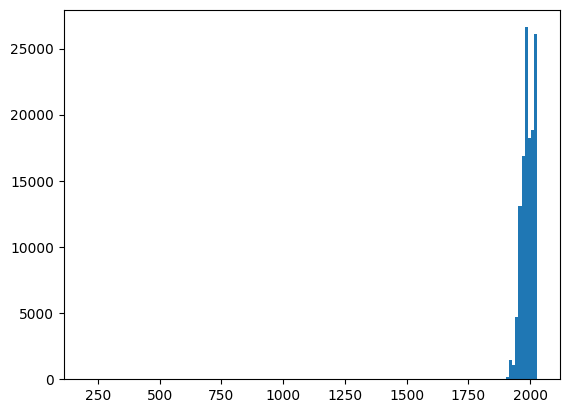

In [263]:
plt.hist(data['yearBuilt'], bins=145)
plt.show()

In [264]:
years.value_counts()

yearBuilt
2024.0    8129
2023.0    4578
2006.0    3299
2005.0    3068
2004.0    2438
          ... 
202.0        1
1895.0       1
1898.0       1
1865.0       1
2027.0       1
Name: count, Length: 148, dtype: int64

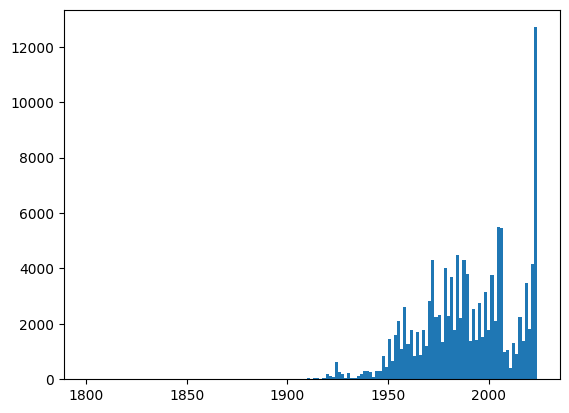

In [265]:
plt.hist(data['yearBuilt'], bins=145, range=(1800,2024))
plt.show()

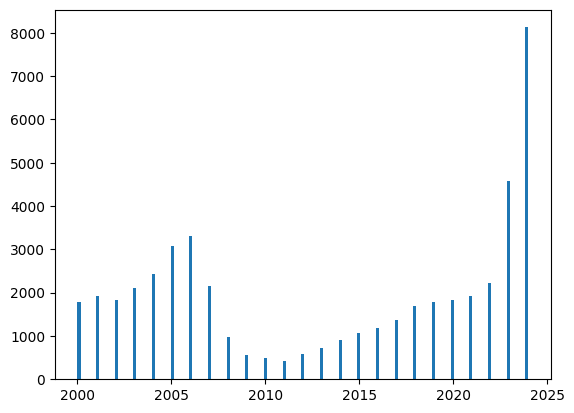

In [266]:
plt.hist(data['yearBuilt'], bins=145, range=(2000,2024))
plt.show()

A few from the 19th C, some from first half 20th, most from 2024. 

Recommend dropping rows with year built past 2025.

# Effect of pool on price

In [267]:
data['pool'].value_counts()

pool
False           108522
0                23794
True             11147
1                 2136
Type Unknown         9
Inground             8
Pool/spa             1
Name: count, dtype: int64

In [268]:
data[data['pool'] == 'Type Unknown']

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,year_month,m_rate
11307,"1221-Biarritz-Dr,-Miami-Beach,-FL-33141","1221 Biarritz Dr, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.853754,-80.132029,Single Family,4.0,...,725000.0,0,0,0,1.0,0,Type Unknown,1.0,2024-03,0.0682
18186,"6300-S-Pointe-Blvd,-Apt-201,-Fort-Myers,-FL-33919","6300 S Pointe Blvd, Apt 201, Fort Myers, FL 33919",Fort Myers,FL,33919,Lee,26.552392,-81.904911,Condo,2.0,...,109900.0,1,1,0,1.0,1,Type Unknown,1.0,2024-03,0.0682
21209,"358-Ne-Genesee-Ave,-Port-Saint-Lucie,-FL-34983","358 Ne Genesee Ave, Port Saint Lucie, FL 34983",Port Saint Lucie,FL,34983,St. Lucie,27.335812,-80.341880,Single Family,3.0,...,397000.0,1,1,0,1.0,1,Type Unknown,1.0,2024-04,0.0699
32705,"3012-Brougham-Ave,-Jacksonville,-FL-32246","3012 Brougham Ave, Jacksonville, FL 32246",Jacksonville,FL,32246,Duval,30.291696,-81.464783,Single Family,3.0,...,525000.0,1,1,0,1.0,1,Type Unknown,1.0,2024-04,0.0699
57747,"1767-Oak-Pond-Ct,-Oldsmar,-FL-34677","1767 Oak Pond Ct, Oldsmar, FL 34677",Oldsmar,FL,34677,Pinellas,28.038162,-82.687592,Single Family,4.0,...,643400.0,1,1,0,2.0,1,Type Unknown,1.0,2024-05,0.0760
61879,"3761-Sw-1st-St,-Fort-Lauderdale,-FL-33312","3761 Sw 1st St, Fort Lauderdale, FL 33312",Fort Lauderdale,FL,33312,Broward,26.119984,-80.198751,Single Family,4.0,...,360000.0,1,0,0,1.0,0,Type Unknown,1.0,2024-05,0.0760
81257,"721-Ne-137th-St,-North-Miami,-FL-33161","721 Ne 137th St, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.901596,-80.184257,Single Family,3.0,...,560000.0,0,0,0,1.0,0,Type Unknown,1.0,2024-05,0.0760
103662,"7907-11th-Ave-NW,-Bradenton,-FL-34209","7907 11th Ave NW, Bradenton, FL 34209",Bradenton,FL,34209,Manatee,27.509208,-82.641532,Single Family,3.0,...,805000.0,1,1,1,1.0,1,Type Unknown,1.0,2024-07,0.0685
121900,"810-Se-5th-Ter,-Pompano-Beach,-FL-33060","810 Se 5th Ter, Pompano Beach, FL 33060",Pompano Beach,FL,33060,Broward,26.219815,-80.114229,Single Family,3.0,...,1750000.0,1,0,0,1.0,1,Type Unknown,1.0,2024-07,0.0685


In [269]:
# Fixing pool column

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).astype(int)

In [270]:
data['pool'].head()

0    0
1    1
2    0
3    0
4    0
Name: pool, dtype: int64

In [271]:
data['pool'].isna().any()

np.False_

In [272]:
# Choosing Jacksonville as the largest city, how does having a pool relate to sale price? 

jacksonville = data[data['city'] == 'Jacksonville']
jacksonville.shape

(5997, 26)

In [273]:
jacksonville['pool'].value_counts()

pool
0    5707
1     290
Name: count, dtype: int64

In [274]:
jacksonville.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5997 entries, 2 to 145606
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                5997 non-null   object             
 1   formattedAddress  5997 non-null   object             
 2   city              5997 non-null   object             
 3   state             5997 non-null   object             
 4   zipCode           5997 non-null   int64              
 5   county            5996 non-null   object             
 6   latitude          5997 non-null   float64            
 7   longitude         5997 non-null   float64            
 8   propertyType      5899 non-null   object             
 9   bedrooms          5819 non-null   float64            
 10  bathrooms         5827 non-null   float64            
 11  squareFootage     5823 non-null   float64            
 12  lotSize           5827 non-null   float64            
 13  yearBu

# Moving towards modeling

In [275]:
# data = data[data['lastSaleDate'] <= '2024-06-01']

In [276]:
data.city.value_counts().head(25)

city
Jacksonville        5997
Miami               4842
Orlando             4248
Tampa               4023
Naples              3132
Cape Coral          2784
Kissimmee           2691
Ocala               2614
Saint Petersburg    2598
Bradenton           2409
Fort Myers          2327
Sarasota            2312
Port Saint Lucie    2195
Saint Augustine     1985
Fort Lauderdale     1925
Davenport           1884
West Palm Beach     1792
Lehigh Acres        1697
Boca Raton          1683
Lakeland            1569
Port Charlotte      1514
Wesley Chapel       1499
The Villages        1448
Pensacola           1420
Delray Beach        1304
Name: count, dtype: int64

In [277]:

data.shape

(145617, 26)

In [278]:
city_counts = data.city.value_counts()
big_cities = city_counts[city_counts >= 1304].index

filtered_by_city = data[data.city.isin(big_cities)]

filtered_by_city.shape

(61892, 26)

In [279]:
property_types = ['Single Family','Condo','Manufactured','Townhouse']
filtered_by_city = filtered_by_city[filtered_by_city['propertyType'].isin(property_types)]
filtered_by_city['propertyType'].value_counts()

propertyType
Single Family    42435
Condo            10143
Manufactured       953
Townhouse          746
Name: count, dtype: int64

In [280]:
test_cols = ['latitude','longitude','bedrooms','bathrooms','squareFootage','lotSize','lastSalePrice','pool','m_rate','cooling','heating','fireplace','garage','floorCount']

filtered_by_city = filtered_by_city[test_cols]
filtered_by_city = filtered_by_city.dropna()
filtered_by_city.shape

(36555, 14)

In [281]:
filtered_by_city = filtered_by_city[(filtered_by_city['lastSalePrice'] < 3000000) & (filtered_by_city['lastSalePrice'] > 10000)]

In [282]:
# Features and target, splitting data, scaling

y = filtered_by_city['lastSalePrice']
X = filtered_by_city.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [283]:
# Linear Regression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 76014291937.3489
Coefficient of determination: 0.44487726450656817


In [284]:
# Random Forest Regressor

regressor = RandomForestRegressor()
regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 41073221611.246346
Coefficient of determination: 0.7000474706104561


In [285]:
X_train_scaled.shape

(28591, 13)